In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y 

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [12]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [13]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [15]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-accuracy': train_acc,
                             'valid-accuracy': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 8s 150us/step - loss: 2.4614 - accuracy: 0.0990 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 7s 150us/step - loss: 2.4614 - accuracy: 0.0982 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.4614 - accuracy: 0.0987 - val_loss: 2.4613 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

50000/50000 [==============================] - 8s 156us/step - loss: 1.7750 - accuracy: 0.4746 - val_loss: 1.7935 - val_accuracy: 0.4610
Epoch 46/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.7706 - accuracy: 0.4749 - val_loss: 1.7938 - val_accuracy: 0.4691
Epoch 47/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.7658 - accuracy: 0.4754 - val_loss: 1.7771 - val_accuracy: 0.4758
Epoch 48/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.7618 - accuracy: 0.4753 - val_loss: 1.8160 - val_accuracy: 0.4534
Epoch 49/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.7589 - accuracy: 0.4792 - val_loss: 1.7958 - val_accuracy: 0.4652
Epoch 50/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.7541 - accuracy: 0.4798 - val_loss: 1.7792 - val_accuracy: 0.4694
Experiment with Regulizer = 0.000000
Model: "model_1"
________________________________________________________________

Epoch 43/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.6427 - accuracy: 0.5174 - val_loss: 1.6929 - val_accuracy: 0.4915
Epoch 44/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.6360 - accuracy: 0.5153 - val_loss: 1.6782 - val_accuracy: 0.4999
Epoch 45/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.6294 - accuracy: 0.5186 - val_loss: 1.6893 - val_accuracy: 0.4930
Epoch 46/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.6275 - accuracy: 0.5201 - val_loss: 1.6791 - val_accuracy: 0.4980
Epoch 47/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.6232 - accuracy: 0.5200 - val_loss: 1.6828 - val_accuracy: 0.4935
Epoch 48/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.6214 - accuracy: 0.5205 - val_loss: 1.6666 - val_accuracy: 0.5060
Epoch 49/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.6137 - accuracy: 0.5215

50000/50000 [==============================] - 8s 153us/step - loss: 1.6587 - accuracy: 0.5140 - val_loss: 1.7158 - val_accuracy: 0.4851
Epoch 41/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.6500 - accuracy: 0.5143 - val_loss: 1.7285 - val_accuracy: 0.4823
Epoch 42/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.6433 - accuracy: 0.5186 - val_loss: 1.7027 - val_accuracy: 0.4952
Epoch 43/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.6409 - accuracy: 0.5174 - val_loss: 1.7004 - val_accuracy: 0.4934
Epoch 44/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.6317 - accuracy: 0.5203 - val_loss: 1.6922 - val_accuracy: 0.4928
Epoch 45/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.6287 - accuracy: 0.5203 - val_loss: 1.6805 - val_accuracy: 0.5023
Epoch 46/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.6243 - accuracy: 0.5214 - val_loss:

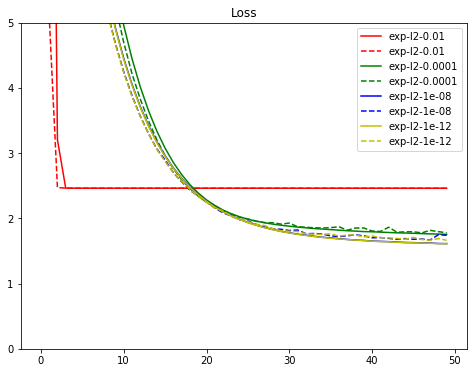

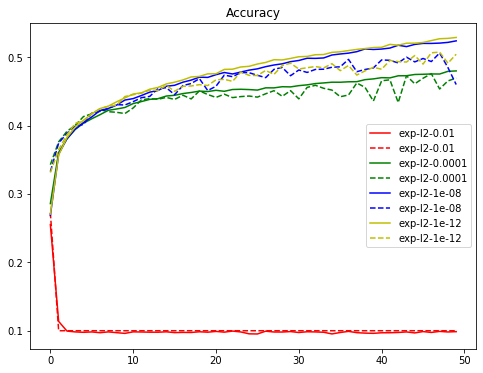

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()